In [1]:
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import util

In [2]:
# Set the random seed for Python's built-in random module
seed = 1
random.seed(seed)

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and Preprocess Data (Fake Data)

In [3]:
# Load Data
data = pd.read_csv('mydata.csv')
# Run PCA to determine the lower dimensionality of the data
components = util.determine_components(data)
# Group the data by the "Class" column
grouped_data = data.groupby('Pressure Condition')

# Create an empty dictionary to store the DataFrames
dfs = {}

# Iterate over each group and store the data in the dictionary
for class_, group in grouped_data:
    dfs[class_] = group.copy()

# Access the separate DataFrames
df_class_1 = dfs[0]
df_class_2 = dfs[1]

# Now that we have two different dataframes we can drop class column
df_class_1 = df_class_1.drop(columns= 'Pressure Condition')
df_class_2 = df_class_2.drop(columns= 'Pressure Condition')

# Column Names saved for later when we remake DataFrames
column_names = df_class_2.columns

6


In [4]:
# util.df_plot(df_class_2)

In [5]:
# Here we Scale the data
# Create an instance of StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()

# Fit the scaler to data
scaler1.fit(df_class_1)
scaler2.fit(df_class_2)

# Transform the data to Standard scale
df_class_1_scaled = scaler1.transform(df_class_1)
df_class_2_scaled = scaler2.transform(df_class_2)

In [6]:
def create_train_test(df, test_size, columns):
    """
    Create a train-test split of the data.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the data.
        test_size (float or int): If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. 
                                  If int, represents the absolute number of test samples.

    Returns:
        pd.DataFrame: A DataFrame containing the training data.
        pd.DataFrame: A DataFrame containing the testing data.
    """
    train_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)
    train_df = pd.DataFrame(train_df, columns = columns)
    test_df = pd.DataFrame(test_df, columns = columns)
    print(f" Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")
    return train_df, test_df

In [7]:
train_df, test_df = create_train_test(df_class_2_scaled, test_size=0.2, columns = column_names)

 Train Shape: (4000, 44), Test Shape: (1000, 44)


# Parameters
#### input_dim = Input dimension, number of features in feature dimension
#### hidden_dim = Hidden dimension, size of the network internals  
#### output_dim = Output dimension, dimension of the embedded space. this is what the feature space is reduced to 
#### encoding_dim = Encoding dimension, should be that of the embedding space
#### noise_dim = Noise dimension, should be that of the embedding space
#### cond_dim = Condition dimension, should be that of the embedding space
#### seq_length = Sequence Length, length of input sequence for data loading into the model
#### input_channels = Dimension of input going into the convolutional layer in discriminator
#### hidden_channels = Size of the hidden discriminator layers
#### num_epochs = Number of training epochs for embedding and recovery networks
#### lr = Learning rate how much the weights are modified at each optimizer step
#### batch_size = batch size is the size of data used in training
#### criterion = Loss function for embedding and recovery networks

In [8]:
input_dim = len(column_names)  
hidden_dim = 50  
output_dim = components 
encoding_dim = output_dim
noise_dim = output_dim
cond_dim = output_dim
seq_length = 20
input_channels = seq_length + 2
hidden_channels = 64
num_epochs = 1
lr = 0.0001  
batch_size = 32
criterion = nn.MSELoss()

In [9]:
class EmbeddingNetwork(nn.Module):
    """
    A PyTorch Module that represents an embedding network.

    This module takes in sequences of a specified dimension, processes them with a Gated Recurrent Unit (GRU) layer,
    then passes the output through a linear layer and a sigmoid activation function to produce embedded sequences.

    Attributes:
        gru (nn.GRU): The GRU layer of the network.
        linear (nn.Linear): A linear layer of the network.
        sigmoid (nn.Sigmoid): The Sigmoid activation function.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EmbeddingNetwork, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        """
        The forward propagation method for the network.

        Args:
            x (torch.Tensor): The input tensor. Shape should be (batch_size, seq_len, input_dim).

        Returns:
            torch.Tensor: The output tensor after being processed by the network. Shape is (batch_size, seq_len, output_dim).
        """
        out, _ = self.gru(x)
        out = self.linear(out)
#         out = self.sigmoid(out)
        return out

class RecoveryNetwork(nn.Module):
    """
    A PyTorch Module that represents a recovery network.

    This module takes in sequences of a specified dimension, processes them with a Gated Recurrent Unit (GRU) layer,
    then passes the output through a linear layer to produce recovered sequences.

    Attributes:
        gru (nn.GRU): The GRU layer of the network.
        linear (nn.Linear): A linear layer of the network.
    """
    def __init__(self, output_dim, hidden_dim, input_dim):
        super(RecoveryNetwork, self).__init__()
        self.gru = nn.GRU(output_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        """
        The forward propagation method for the network.

        Args:
            x (torch.Tensor): The input tensor. Shape should be (batch_size, seq_len, output_dim).

        Returns:
            torch.Tensor: The output tensor after being processed by the network. Shape is (batch_size, seq_len, input_dim).
        """
        out, _ = self.gru(x)
        out = self.linear(out)
        return out


In [10]:
class TimeSeriesDataset(Dataset):
    """
    A PyTorch Dataset for handling time series data.

    This class is designed to create subsequences of a specified length from a given time series. These subsequences
    can then be used as input for sequence-to-sequence prediction tasks, such as forecasting or anomaly detection.

    Attributes:
        data (torch.Tensor): The entire time series, converted to a PyTorch tensor.
        seq_length (int): The length of the subsequences that will be produced.
    """
    def __init__(self, data, seq_length):
        """
        Initializes the TimeSeriesDataset instance.

        Args:
            data (pd.DataFrame or np.ndarray): The entire time series. Can be a pandas DataFrame or a numpy array.
            seq_length (int): The length of the subsequences that will be produced.
        """
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        """
        Returns the number of subsequences that can be produced from the time series.

        Returns:
            int: The number of subsequences.
        """
        return len(self.data) - self.seq_length + 1

    def __getitem__(self, index):
        """
        Returns the subsequence starting at a specific index in the time series.

        Args:
            index (int): The start index for the subsequence.

        Returns:
            torch.Tensor: The subsequence of length seq_length starting at the given index.
        """
        return self.data[index:index+self.seq_length]


# Instantiate the Dataset, Dataloader, Embedding and Recovery Networks

In [11]:
dataset = TimeSeriesDataset(train_df, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
embedding_network = EmbeddingNetwork(input_dim, hidden_dim, encoding_dim)
recovery_network = RecoveryNetwork(encoding_dim, hidden_dim, input_dim)

# Training Loop for Embedder and Recovery Networks

In [12]:
def train_autoencoder(embedding_network, recovery_network, dataloader, input_dim, num_epochs, lr):
    """
    Train the autoencoder consisting of an EmbeddingNetwork and a RecoveryNetwork.

    The autoencoder is trained using the Adam optimizer and the MSE loss function. The loss is calculated by comparing
    the output of the autoencoder with the original input. The goal is to minimize the reconstruction error.

    Args:
        embedding_network (nn.Module): The encoder part of the autoencoder.
        recovery_network (nn.Module): The decoder part of the autoencoder.
        dataloader (DataLoader): The dataloader that provides the training data.
        input_dim (int): The dimensionality of the input data.
        num_epochs (int): The number of epochs for training.
        lr (float): The learning rate for the Adam optimizer.

    Returns:
        list: The losses at the end of each epoch.
    """
    losses = []

    embedding_optimizer = torch.optim.Adam(embedding_network.parameters(), lr=lr, weight_decay=1e-5)
    recovery_optimizer = torch.optim.Adam(recovery_network.parameters(), lr=lr, weight_decay=1e-5)

    for epoch in range(num_epochs):
        for seqs_in in dataloader:

            # Ensure the seqs are of correct size
#             seqs_in = seqs_in.view(seqs_in.size(0), -1, input_dim)

            # Zero the gradients
            embedding_optimizer.zero_grad()
            recovery_optimizer.zero_grad()

            # Pass the input sequences through the autoencoder
            encoded = embedding_network(seqs_in)
            decoded = recovery_network(encoded)

            # Calculate the loss
            loss = criterion(decoded, seqs_in)  # The goal is to reconstruct the input sequences

            # Backward propagation
            loss.backward()

            # Update the weights
            embedding_optimizer.step()
            recovery_optimizer.step()

        losses.append(loss.item())

        # Print loss for every 10th epoch
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    return losses

In [13]:
losses = train_autoencoder(embedding_network, recovery_network, dataloader, input_dim, num_epochs, lr)

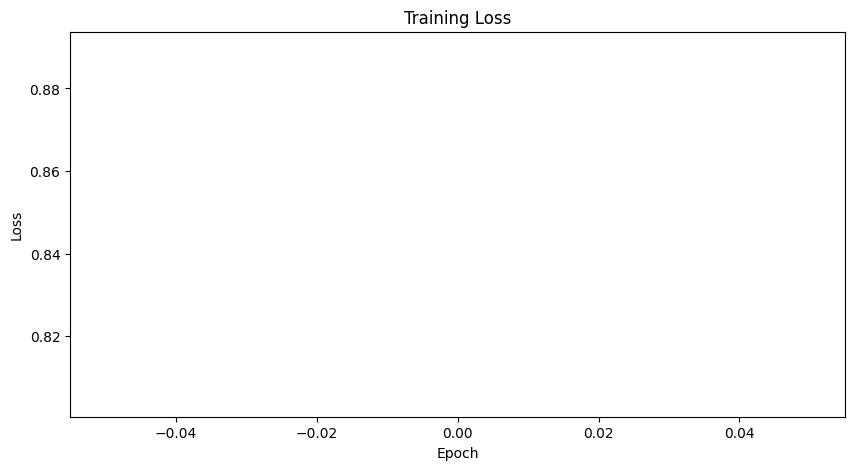

In [14]:
util.plot_losses(losses)

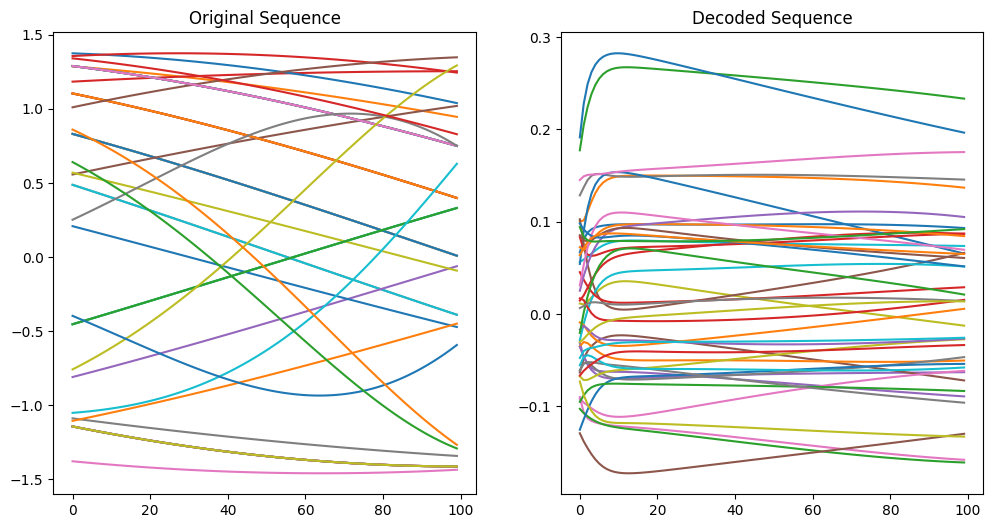

In [15]:
test_data = test_df.iloc[400:500]
util.plot_sequences(test_data, embedding_network, recovery_network)

In [16]:
def plot_sequences(df, embedding_network, recovery_network, num_cols=None):
    """
    Function to plot and compare the original and decoded sequences.

    This function converts a DataFrame to a PyTorch tensor, passes it through the embedding
    and recovery networks, and then plots the specified number of columns of the original
    and recovered data for comparison.

    Parameters:
    df (pandas.DataFrame): The DataFrame to fetch the data from.
    embedding_network (torch.nn.Module): The embedding network used to transform the original sequence.
    recovery_network (torch.nn.Module): The recovery network used to recover the sequence from the embeddings.
    num_cols (int, optional): The number of columns of data to plot. If not provided, it will plot all columns.

    Returns:
    None. The function directly plots the original and decoded sequences using matplotlib.
    """

    # Convert DataFrame to tensor
    test_data_in = torch.tensor(df.values).float()

    # Add an extra dimension for batch size
    test_data_in = test_data_in.unsqueeze(0)

    # Pass the test data through the embedding and recovery networks
    encoded = embedding_network(test_data_in)
    decoded = recovery_network(encoded)
    test_data_in = test_data_in.detach().numpy()
    decoded = decoded.detach().numpy()

    # Select sequences for comparison
    original_sequences = test_data_in[0]
    decoded_sequences = decoded[0]

    if num_cols is None:
        num_cols = len(df.columns)

    # Plotting
    num_plots = min(num_cols, len(df.columns))
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_plots, figsize=(12, 8))

    for i in range(num_plots):
        # Plot original sequence
        axes[0, i].plot(original_sequences[:, i])
        axes[0, i].set_title("Original Sequence {}".format(i+1))

        # Plot decoded sequence
        axes[1, i].plot(decoded_sequences[:, i])
        axes[1, i].set_title("Decoded Sequence {}".format(i+1))

    plt.tight_layout()
    plt.show()


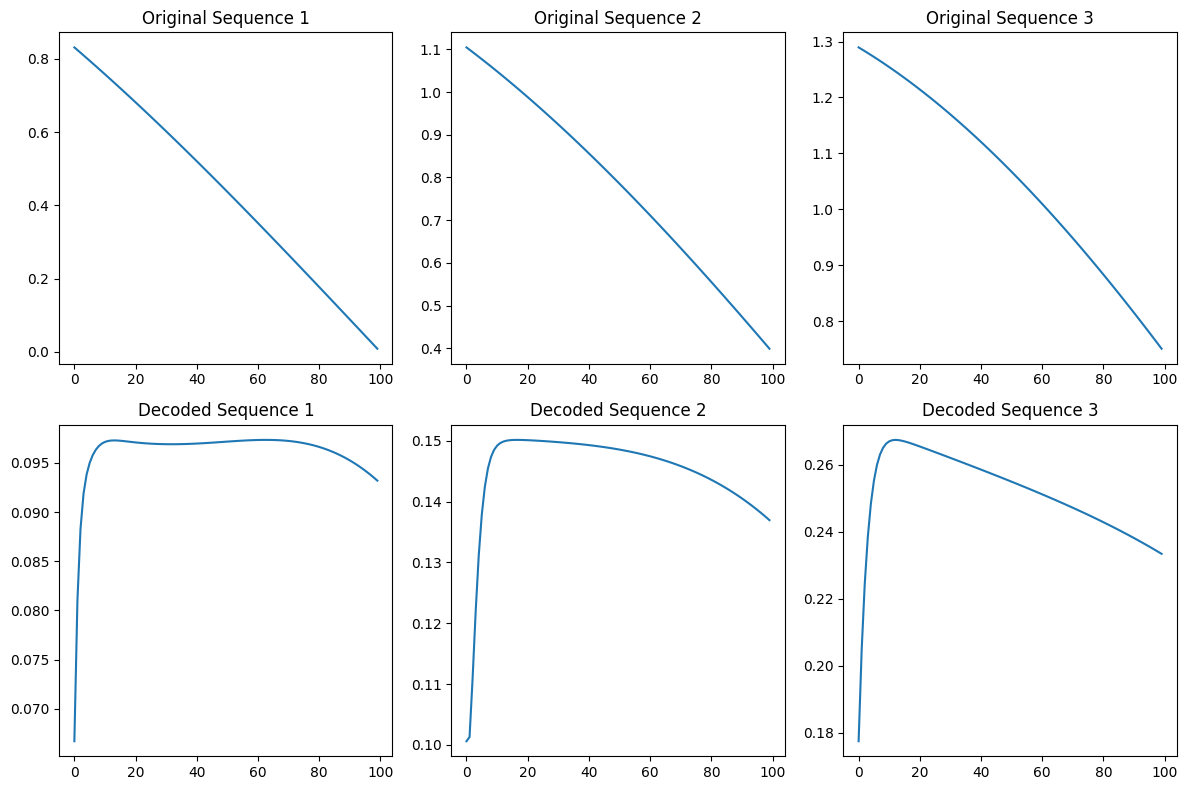

In [17]:
plot_sequences(test_data , embedding_network, recovery_network, num_cols=3)

In [18]:
class ConditionalGenerator(nn.Module):
    """
    A conditional generator in a Generative Adversarial Network (GAN).

    This generator takes a noise tensor and a condition tensor as input and generates
    synthetic data that is conditioned on the given condition.

    Attributes:
        noise_layer (nn.Linear): Transforms the noise tensor into the hidden space.
        condition_layer (nn.Linear): Transforms the condition tensor into the hidden space.
        gru (nn.GRU): A GRU unit that processes the combined noise and condition tensor.
        fc (nn.Linear): Transforms the GRU output into the output space.
    """
    def __init__(self, noise_dim, cond_dim, hidden_dim, output_dim):
        super().__init__()
        self.noise_layer = nn.Linear(noise_dim, hidden_dim)
        self.condition_layer = nn.Linear(cond_dim, hidden_dim)
        self.gru = nn.GRU(input_size=hidden_dim*2, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, noise, condition):
        """
        Forward pass of the conditional generator.

        Args:
            noise (torch.Tensor): The noise tensor.
            condition (torch.Tensor): The condition tensor.

        Returns:
            torch.Tensor: The generated synthetic data.
        """
        batch_size, seq_len, _ = noise.size()
        noise_embedding = F.relu(self.noise_layer(noise.view(batch_size * seq_len, -1)))
        noise_embedding = noise_embedding.view(batch_size, seq_len, -1)
        condition_embedding = F.relu(self.condition_layer(condition))
        condition_embedding = condition_embedding.unsqueeze(1).repeat(1, seq_len, 1)
        # Adjust the batch size of condition_embedding to match noise_embedding
        # Adjust the batch size of condition_embedding to match noise_embedding
        if len(condition_embedding.shape) == 2:  # condition tensor has a batch dimension
            if condition_embedding.size(0) < batch_size:
                condition_embedding = condition_embedding.repeat(batch_size, 1, 1)
        elif len(condition_embedding.shape) == 1:  # condition tensor doesn't have a batch dimension
            condition_embedding = condition_embedding.unsqueeze(0).repeat(batch_size, 1, 1)

        combined = torch.cat([noise_embedding, condition_embedding], dim=2)
        output, _ = self.gru(combined)
        output = self.fc(output)

        return torch.tanh(output)
    
class ConditionalDiscriminator(nn.Module):
    """
    A conditional discriminator in a Generative Adversarial Network (GAN).

    This discriminator takes real or synthetic data and a condition tensor as input and outputs
    a score indicating the "realness" of the data given the condition.

    Attributes:
        conv1 (nn.Conv1d): The first convolutional layer.
        pool1 (nn.MaxPool1d): The first pooling layer.
        conv2 (nn.Conv1d): The second convolutional layer.
        pool2 (nn.MaxPool1d): The second pooling layer.
        fc (nn.Linear): The final linear layer.
    """
    def __init__(self, input_channels, hidden_channels, output_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # dummy input to compute flattening size
        x = torch.zeros(1, input_channels, output_dim)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Linear(in_features=self.flattened_size, out_features=1)

    def forward(self, x, condition):
        """
        Forward pass of the conditional discriminator.

        Args:
            x (torch.Tensor): The input data, which can be real or synthetic.
            condition (torch.Tensor): The condition tensor.

        Returns:
            torch.Tensor: The score indicating the "realness" of the data given the condition.
        """
        x = torch.cat([x, condition.unsqueeze(1)], dim=1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = torch.sigmoid(self.fc(x))

        return x

In [19]:
# Instantiate your models
generator = ConditionalGenerator(noise_dim, cond_dim, hidden_dim, output_dim)
discriminator = ConditionalDiscriminator(input_channels, hidden_channels, output_dim)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
embedding_optimizer = torch.optim.Adam(embedding_network.parameters(), lr=lr, weight_decay=1e-5)
recovery_optimizer = torch.optim.Adam(recovery_network.parameters(), lr=lr, weight_decay=1e-5)

In [20]:
def train_GAN(dataloader, embedding_network, generator, discriminator, recovery_network, generator_optimizer, discriminator_optimizer, num_epochs=3, print_every=10):
    """
    Train a conditional generative adversarial network (GAN).

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        embedding_network (nn.Module): Embedding network to encode the input data.
        generator (nn.Module): Generator network to generate synthetic data.
        discriminator (nn.Module): Discriminator network to distinguish real and synthetic data.
        recovery_network (nn.Module): Recovery network to reconstruct the input from the generated data.
        generator_optimizer (torch.optim.Optimizer): Optimizer for the generator.
        discriminator_optimizer (torch.optim.Optimizer): Optimizer for the discriminator.
        num_epochs (int, optional): Number of epochs to train for. Default is 3.
        print_every (int, optional): How often to print the loss. Default is every 10 epochs.

    Returns:
        list: List of generator losses.
        list: List of discriminator losses.
        list: List of reconstruction losses.
    """
    gen_losses = []
    dis_losses = []
    rec_losses = []
    
    for epoch in range(num_epochs):
        for batch in dataloader:
            # Encode the data
            encoded = embedding_network(batch)
            condition = encoded[:,0,:]

            # Generate fake data
            noise = torch.randn(encoded.shape)
            generated = generator(noise, condition)

            # Discriminator loss
            real_data = torch.cat((encoded, condition.unsqueeze(1)), dim=1)  # Add extra dimension to condition
            fake_data = torch.cat((generated, condition.unsqueeze(1)), dim=1)
            real_preds = discriminator(real_data, condition)
            fake_preds = discriminator(fake_data.detach(), condition)  # Detach so we don't backprop through G

            real_loss = F.binary_cross_entropy(real_preds, torch.ones_like(real_preds))
            fake_loss = F.binary_cross_entropy(fake_preds, torch.zeros_like(fake_preds))
            discriminator_loss = (real_loss + fake_loss) / 2

            # Backprop and update D weights
            discriminator.zero_grad()
            discriminator_loss.backward(retain_graph=True)
            discriminator_optimizer.step()
    
            # Generator loss
            fake_preds = discriminator(fake_data, condition)
            # Changed to Mean Squared Error loss
            generator_loss = F.mse_loss(fake_preds, torch.ones_like(fake_preds))

            # Backprop and update G weights
            generator.zero_grad()
            generator_loss.backward(retain_graph=True)
            generator_optimizer.step()

            # Decode the generated data and compute reconstruction loss
            recovery = recovery_network(generated)
            # Compute MSE between the recovery and the original data
            rec_loss = F.mse_loss(recovery, batch)
        rec_losses.append(rec_loss)
        gen_losses.append(generator_loss)
        dis_losses.append(discriminator_loss)
        
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{num_epochs}, '
                  f'Generator Loss: {generator_loss.item():.5f}, '
                  f'Discriminator Loss: {discriminator_loss.item():.5f}, '
                  f'Reconstruction Loss: {rec_loss.item():.5f}')

    return gen_losses, dis_losses, rec_losses



In [21]:
num_epochs = 1
gen_losses, dis_losses, rec_losses = train_GAN(dataloader, embedding_network, generator, discriminator, recovery_network, generator_optimizer, discriminator_optimizer, num_epochs, print_every=10)

Epoch 0/1, Generator Loss: 0.27769, Discriminator Loss: 0.66491, Reconstruction Loss: 0.84165


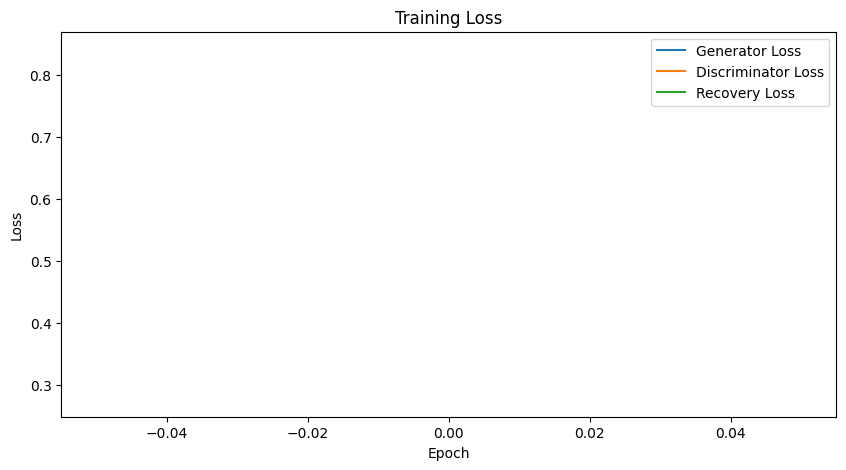

In [22]:
util.plot_multiple_losses([gen_losses,dis_losses,rec_losses], ['Generator Loss', 'Discriminator Loss', 'Recovery Loss'])

# Test Data Generation
## Input requires a dataframe
## The first row of the dataframe is used as the first condition
## Subsequent conditions use the last row of the previous generated sequence 

In [23]:
# Parameters: 
# num_samples = number of samples/sequences
# seq_length = sequence length, length of each sequence
num_samples = 70
seq_length = 20
# Specify test data
test_data_gen = test_df.iloc[0:1400]
test_data_tensor = torch.from_numpy(test_data_gen.values).unsqueeze(0).float()  
# Encode and determine condition
encoded = embedding_network(test_data_tensor)
condition = encoded[:,0,:]
# generate new data and inverse transform the values
recovered_sequences = util.generate_timeseries_sequences(generator, recovery_network, embedding_network, test_data_gen, num_samples, seq_length)
recovered_sequences = scaler2.inverse_transform(recovered_sequences)
test_data_inverse = scaler2.inverse_transform(test_data_gen)
recovered_sequences.shape, test_data_inverse.shape

((1400, 44), (1000, 44))

In [24]:
# file_name = 'generated_data.csv'
# util.array_to_dataframe(recovered_sequences, column_names, file_name)

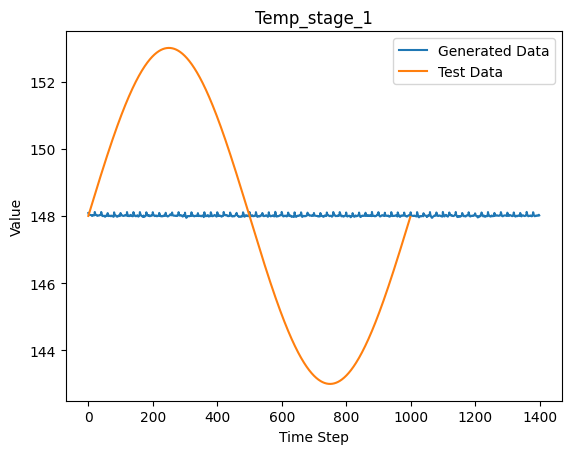

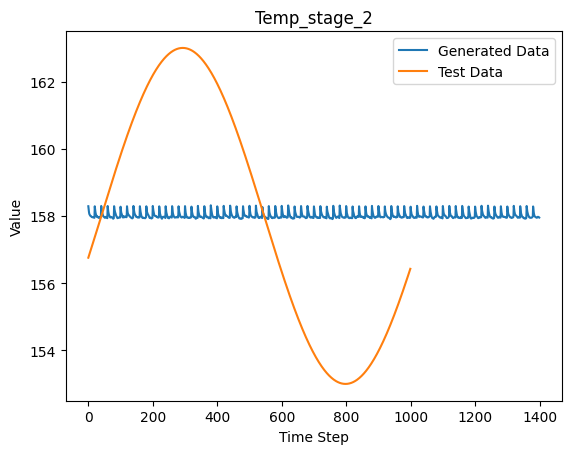

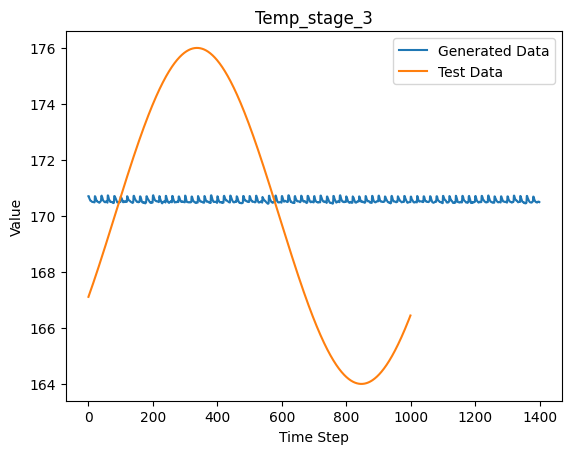

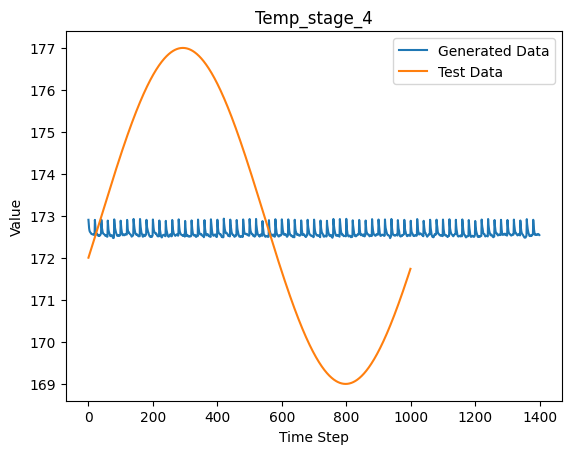

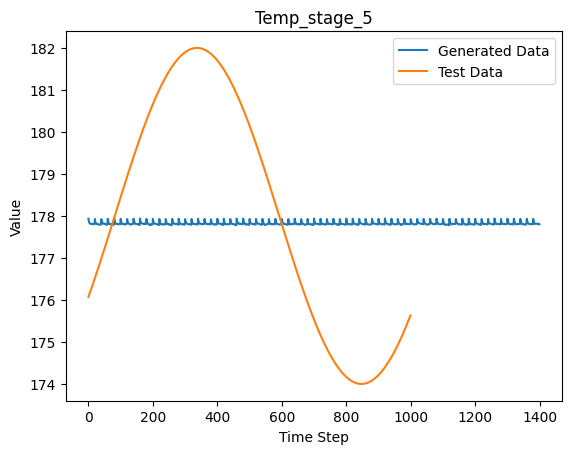

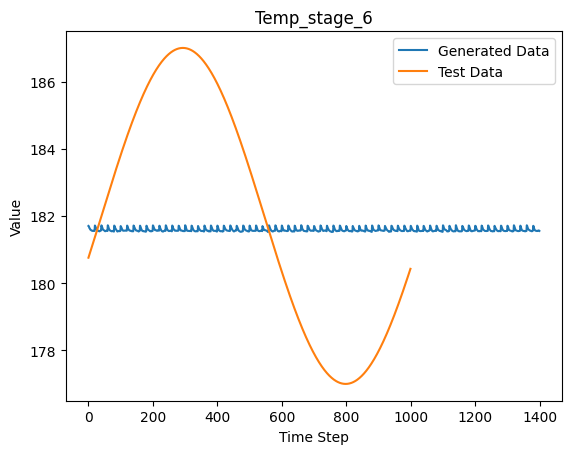

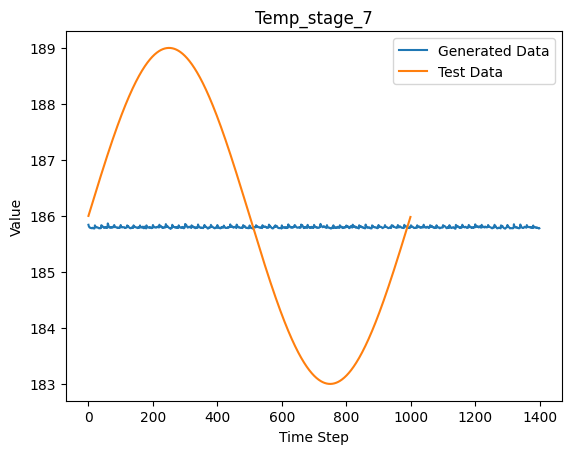

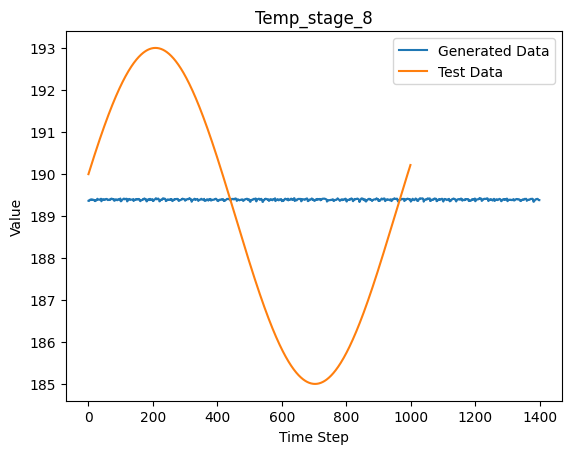

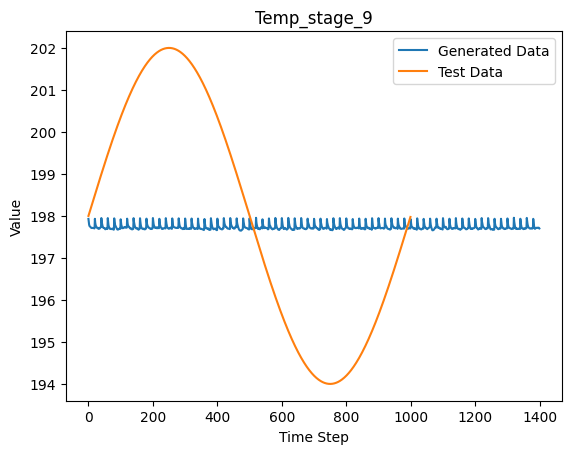

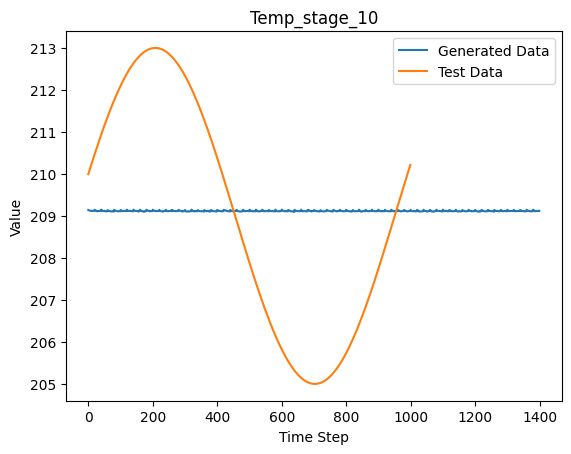

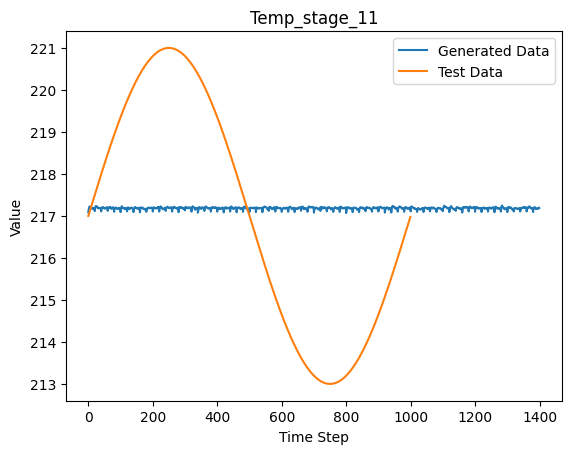

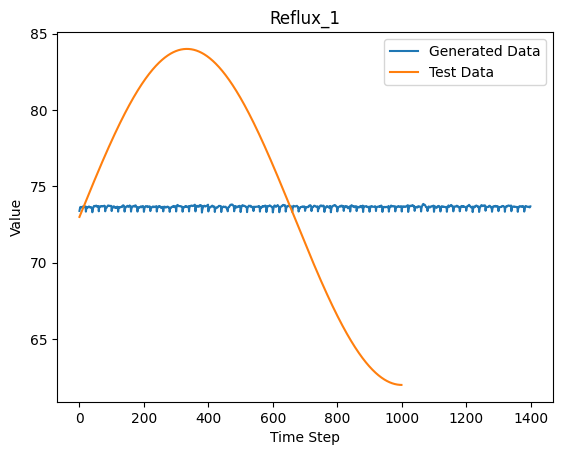

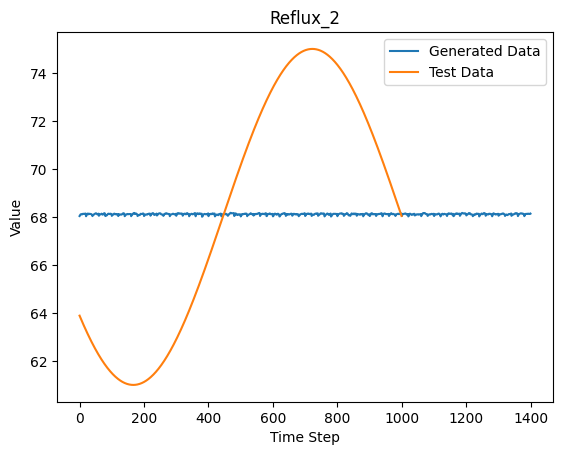

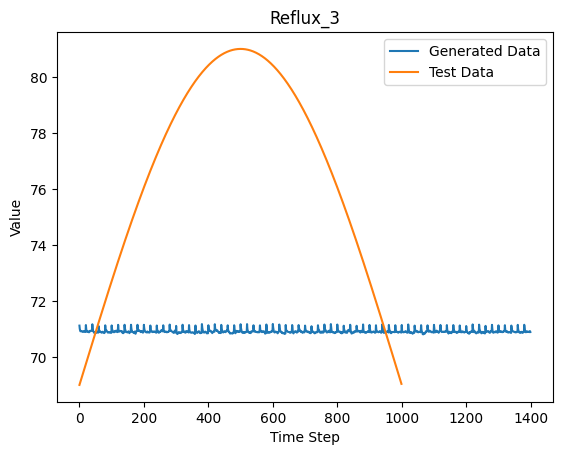

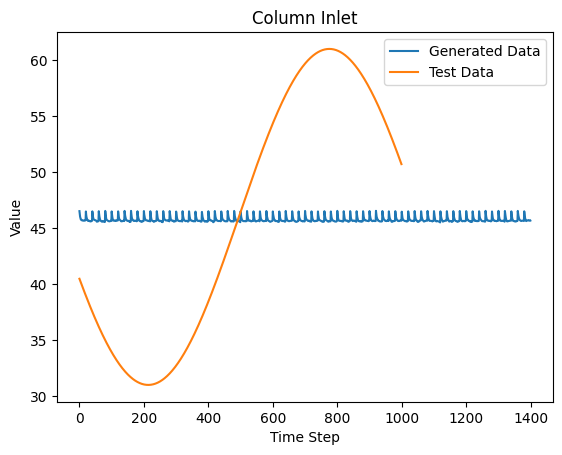

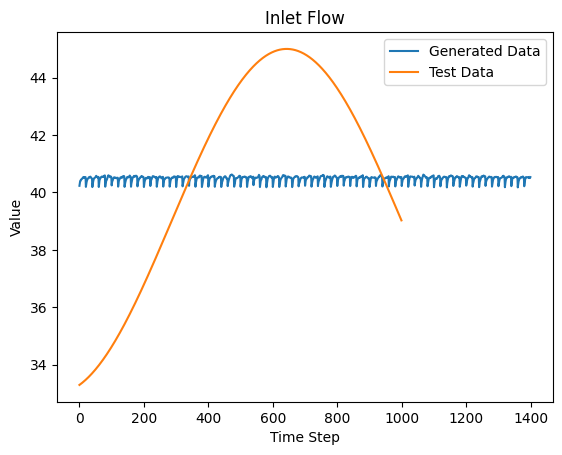

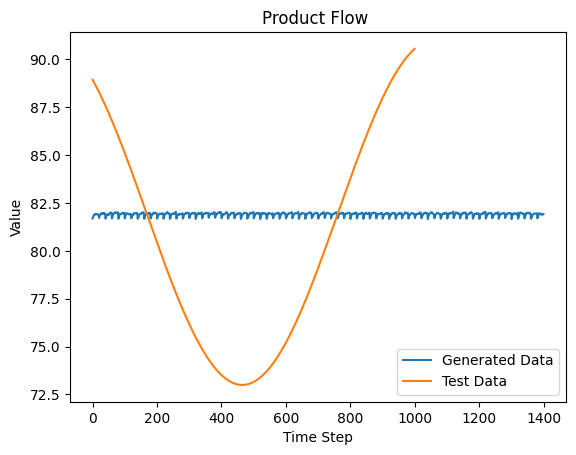

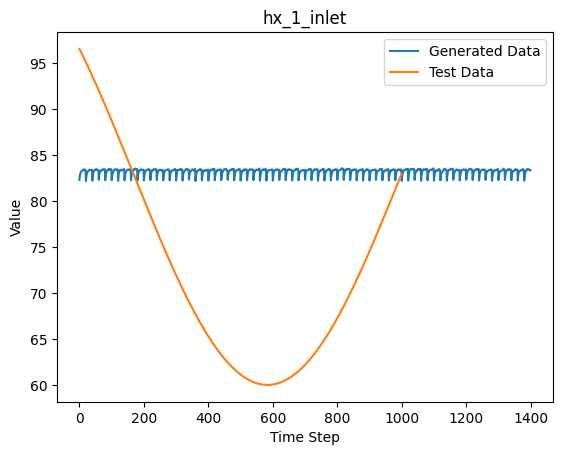

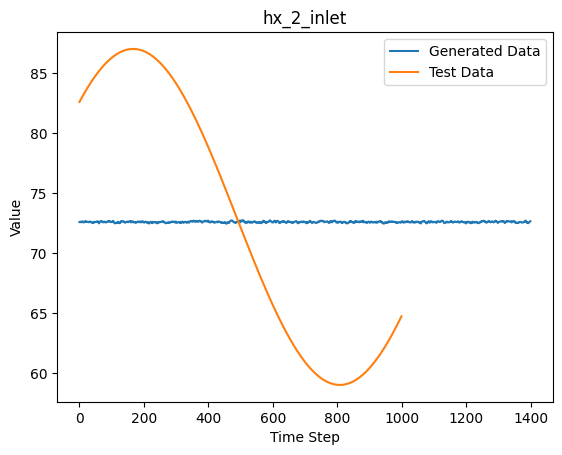

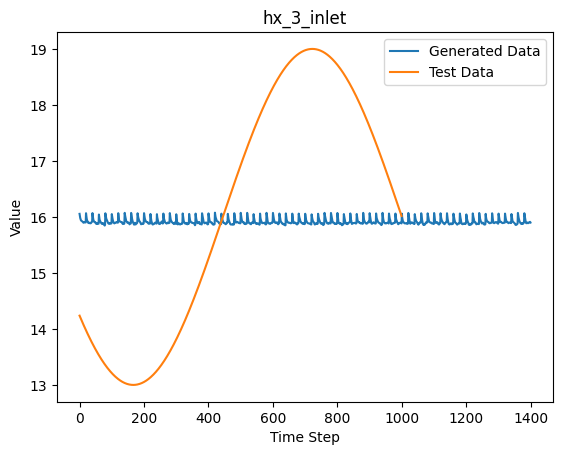

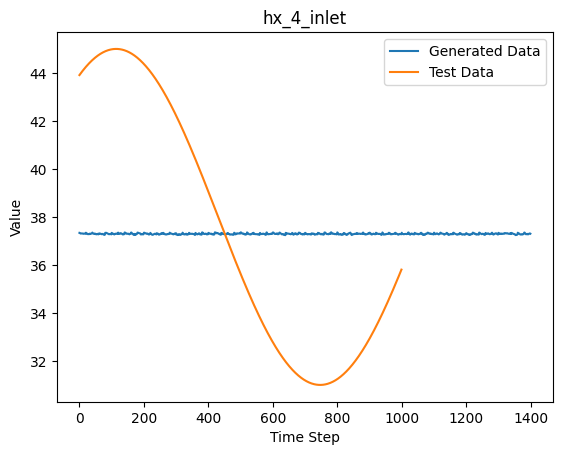

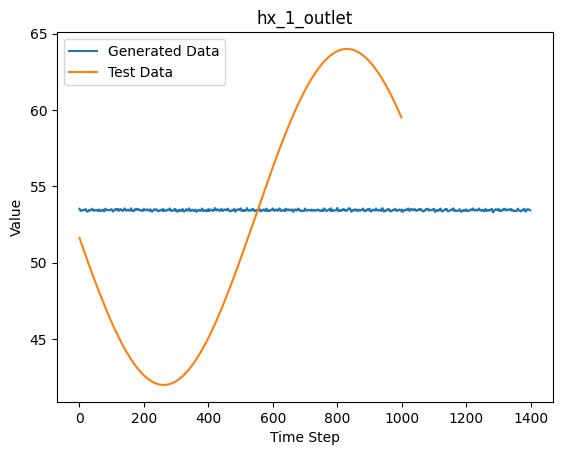

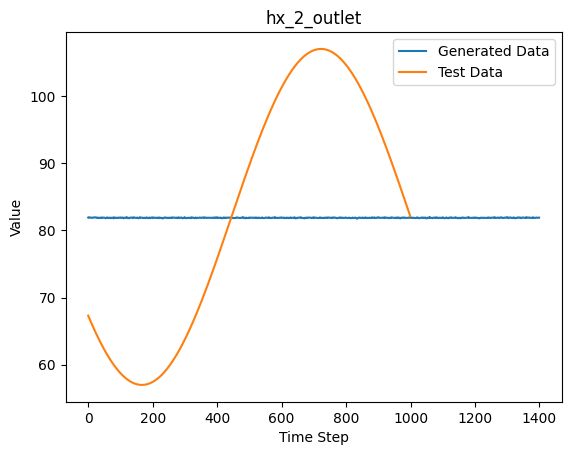

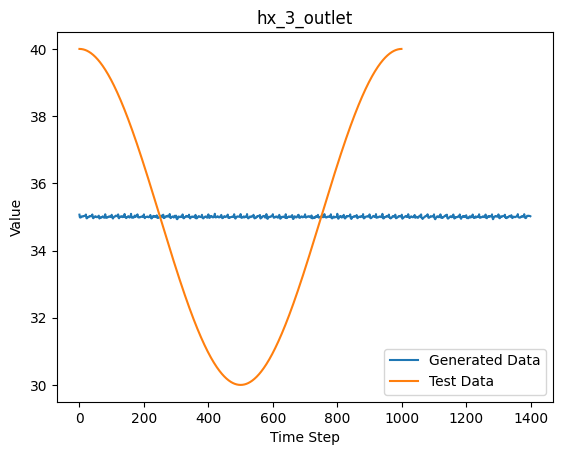

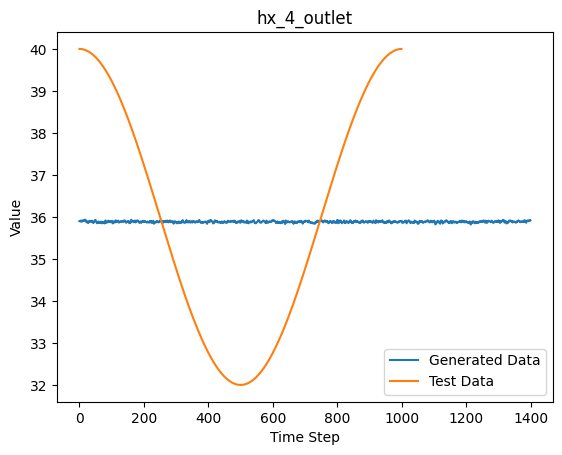

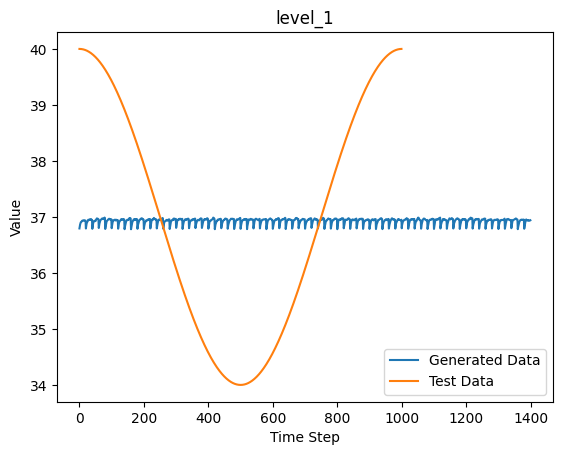

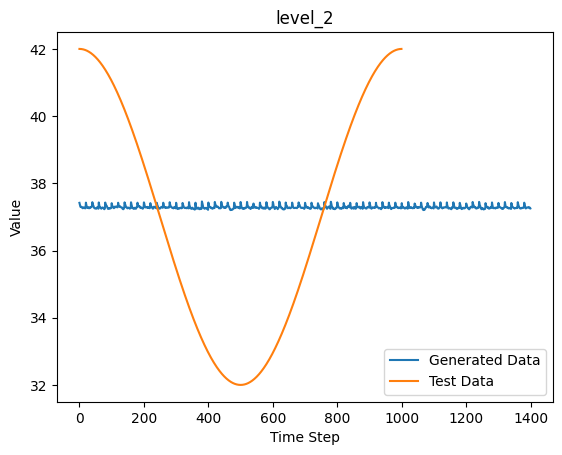

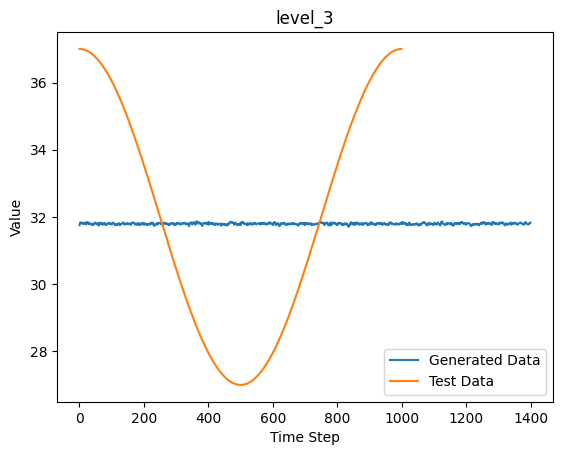

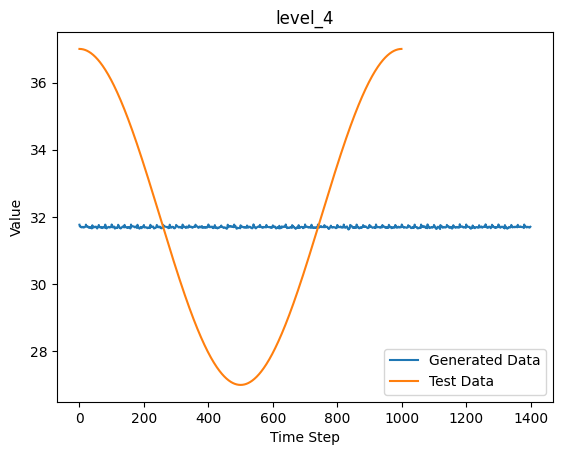

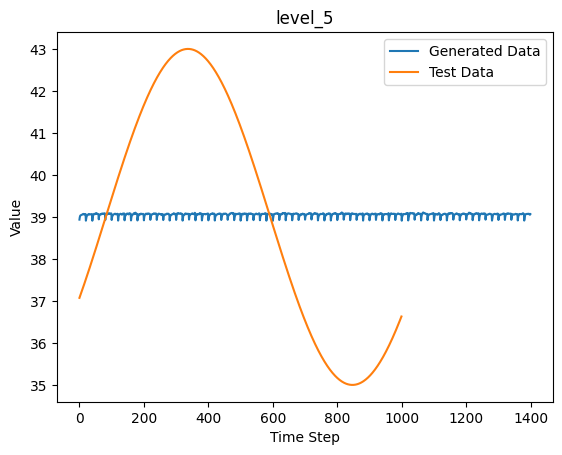

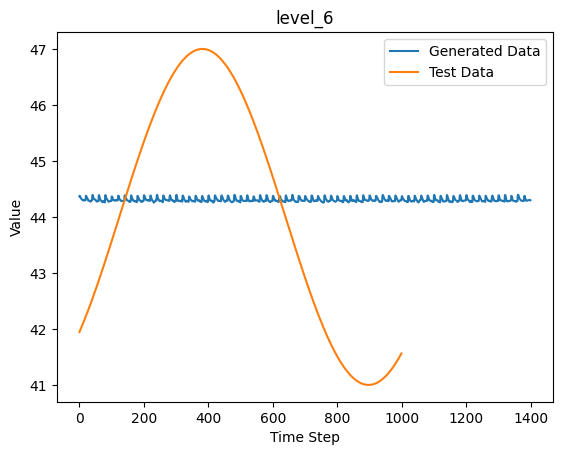

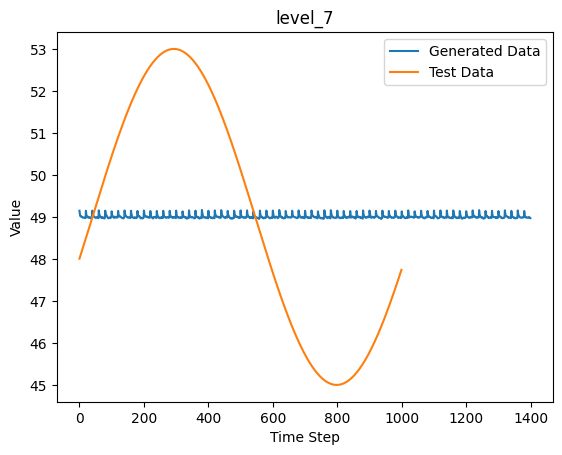

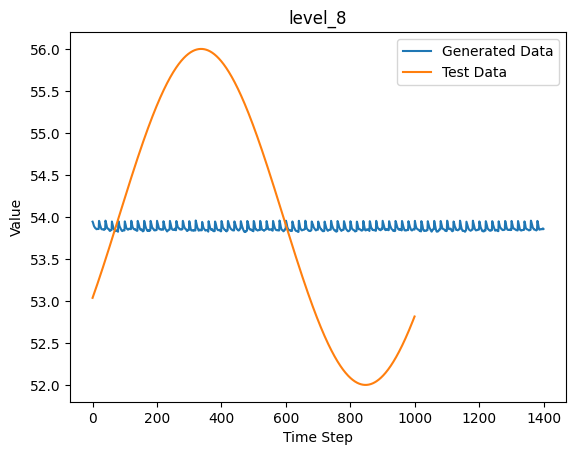

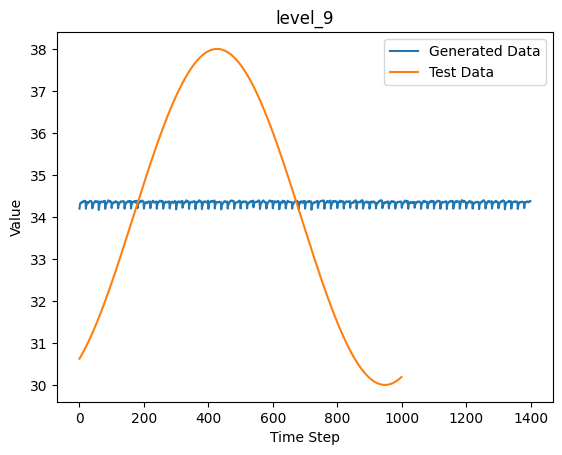

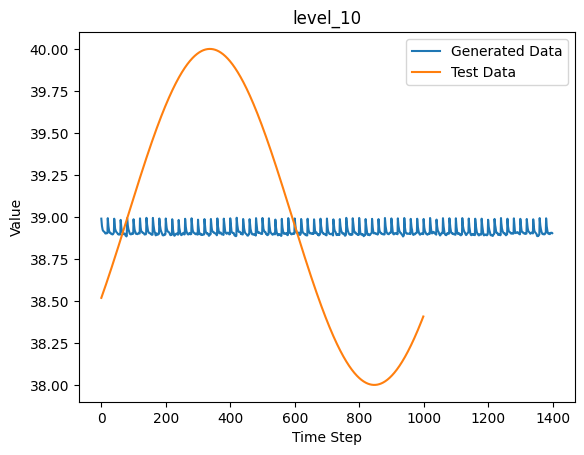

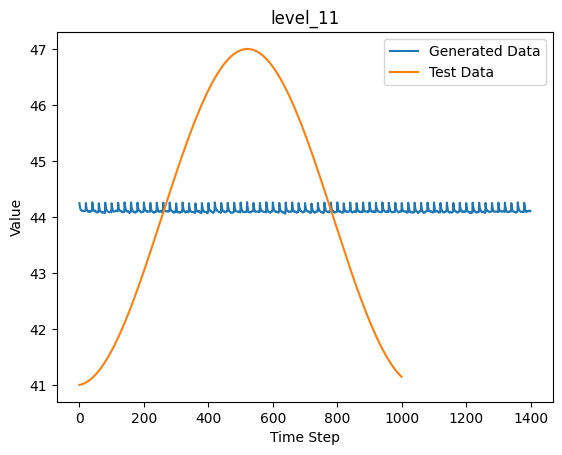

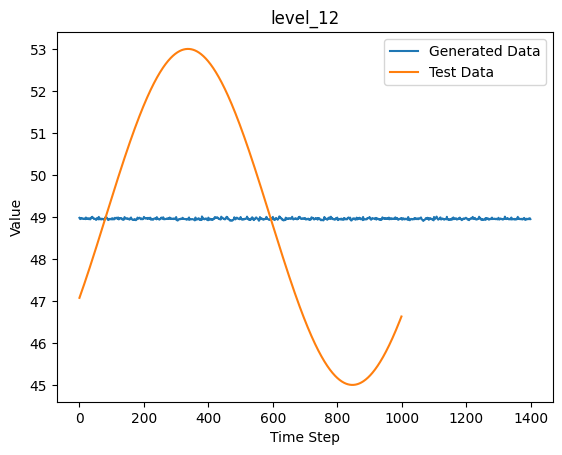

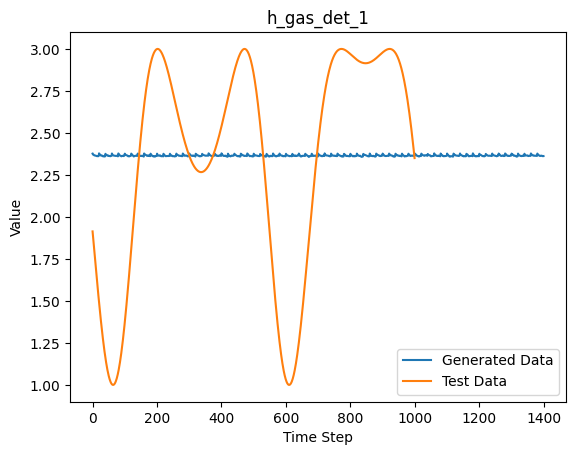

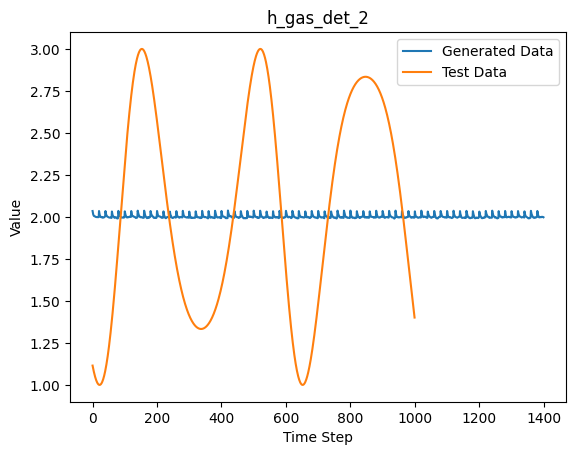

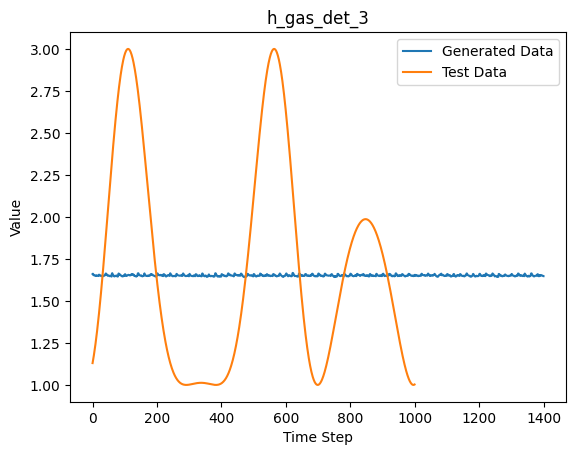

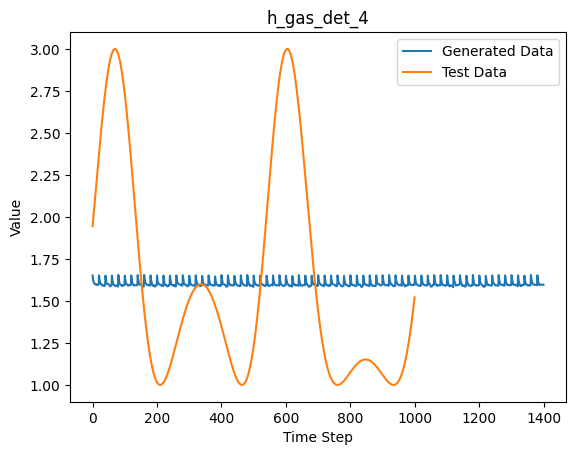

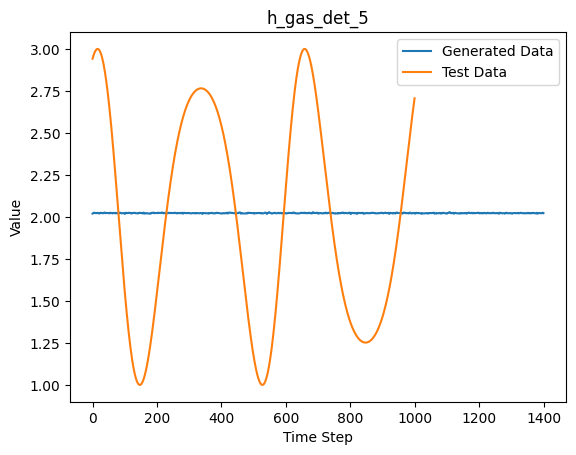

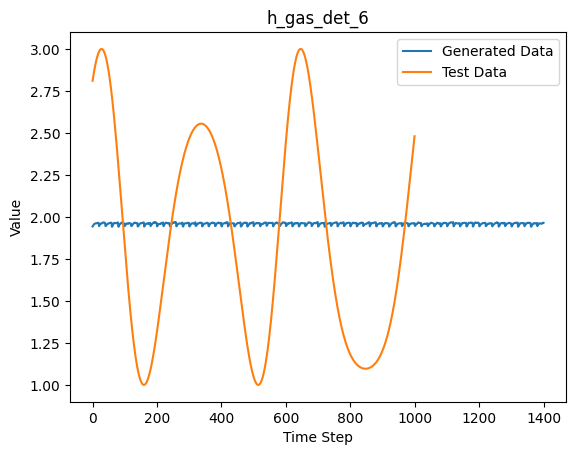

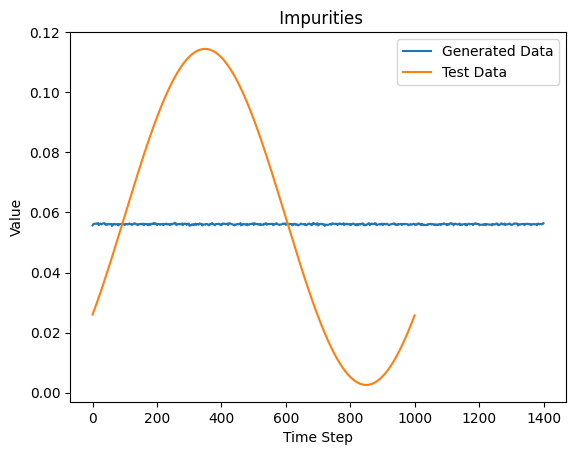

In [25]:
util.plot_features(test_data_inverse, recovered_sequences, column_names, input_dim)

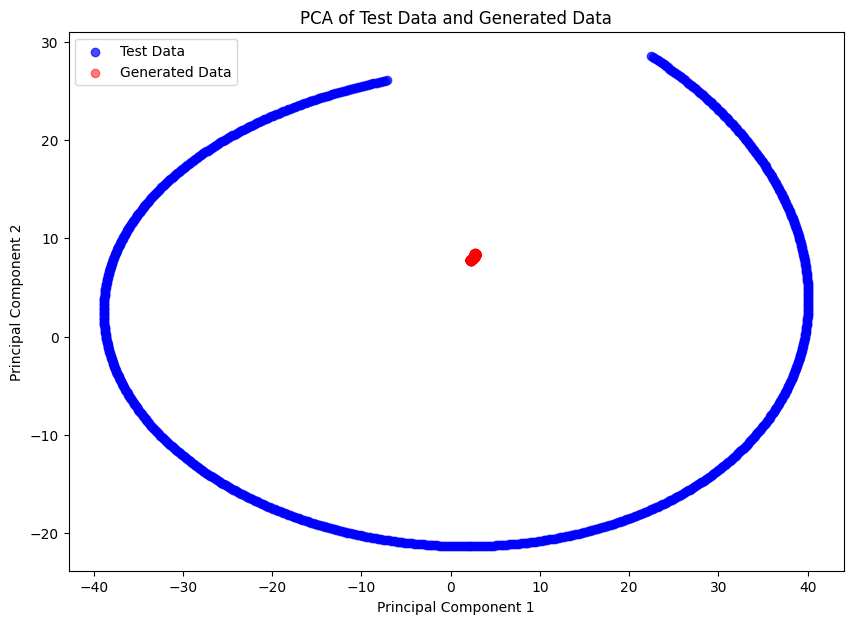

In [26]:
util.plot_pca(test_data_inverse, recovered_sequences)

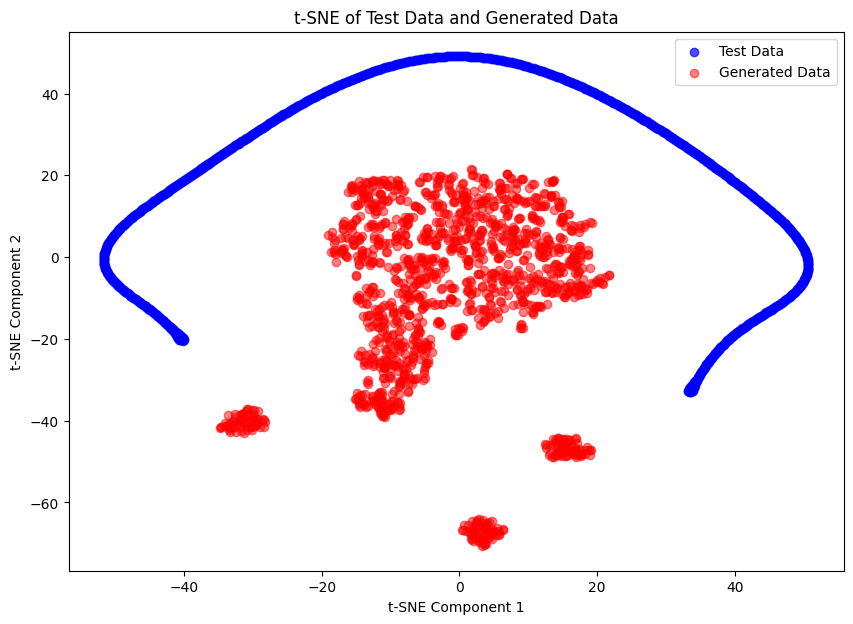

In [27]:
util.plot_tsne(test_data_inverse, recovered_sequences)

# Test Data Augmentation
## Input requires a dataframe with length divisible by the sequence length
## A every sequence length the first row of the dataframe is used as a condition

In [28]:
# Parameters: 
# num_samples = number of samples/sequences
# seq_length = sequence length, length of each sequence
num_samples = 1
seq_length = 20
# Specify test data
test_data_aug = test_df.iloc[0:1400]

# generate new data and inverse transform the values
augmented_data = util.augment_timeseries_sequences(generator, recovery_network, embedding_network, test_data_aug, num_samples, seq_length)
augmented_data = scaler2.inverse_transform(augmented_data)
test_data_inv = scaler2.inverse_transform(test_data_aug)

In [29]:
# file_name = 'augmented_data.csv'
# util.array_to_dataframe(augmented_data, column_names, file_name)

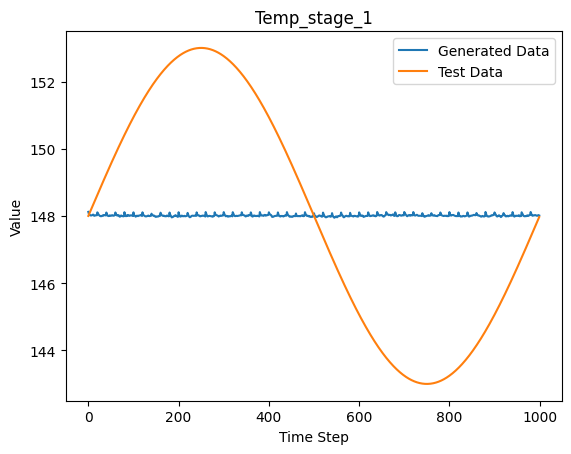

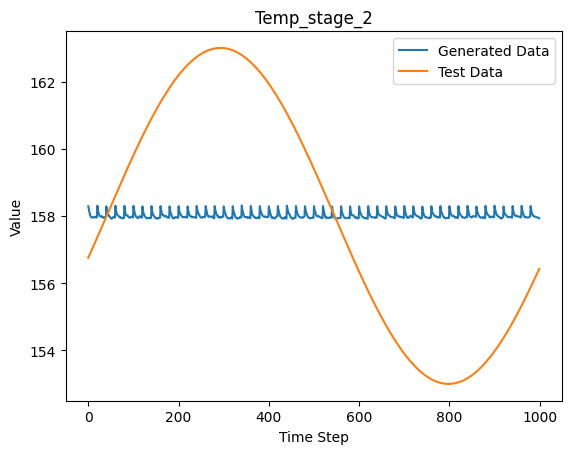

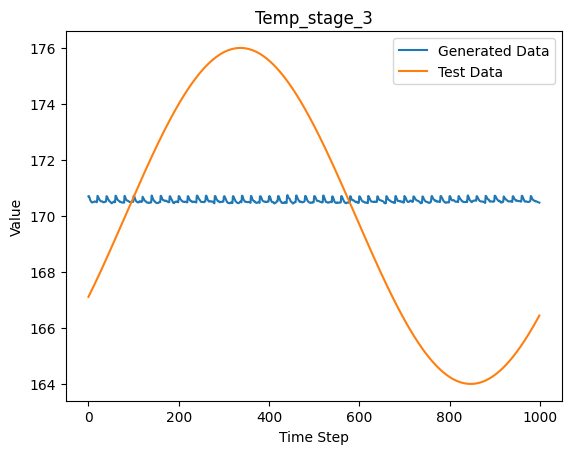

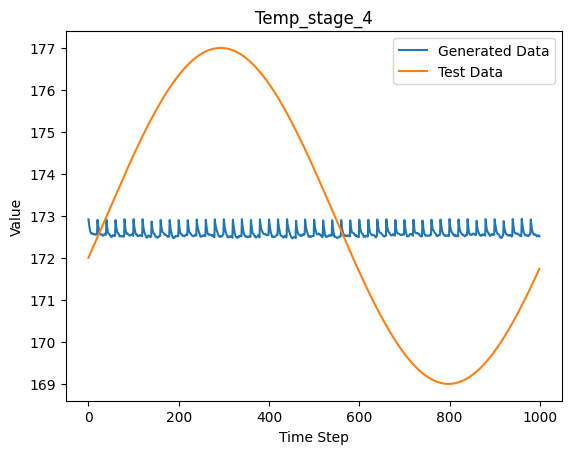

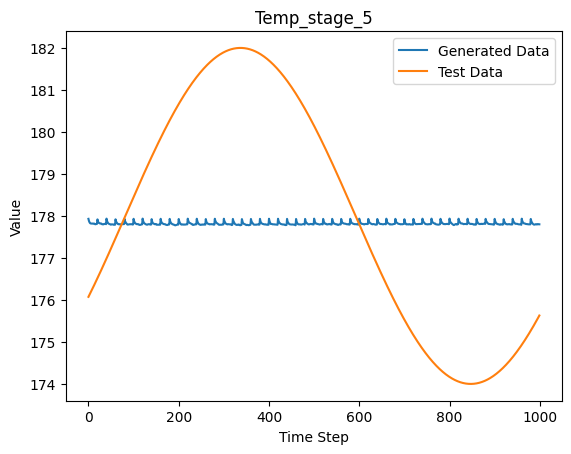

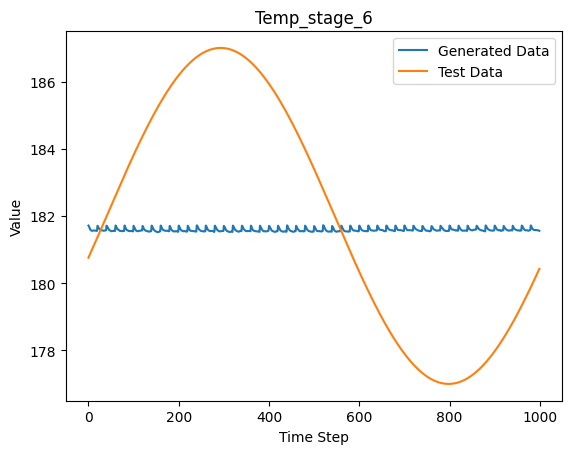

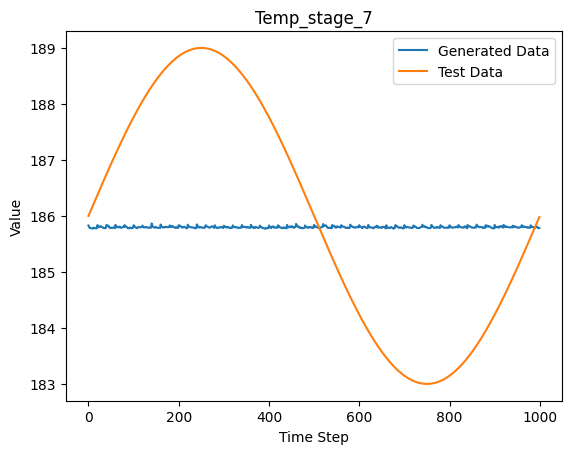

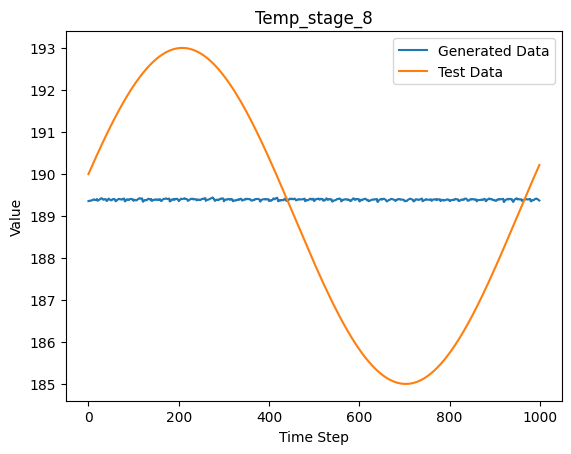

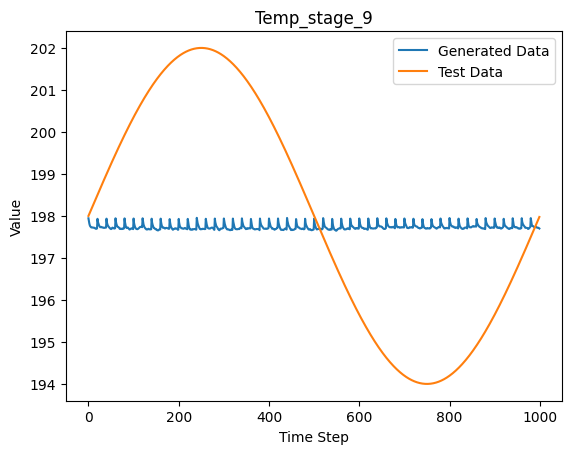

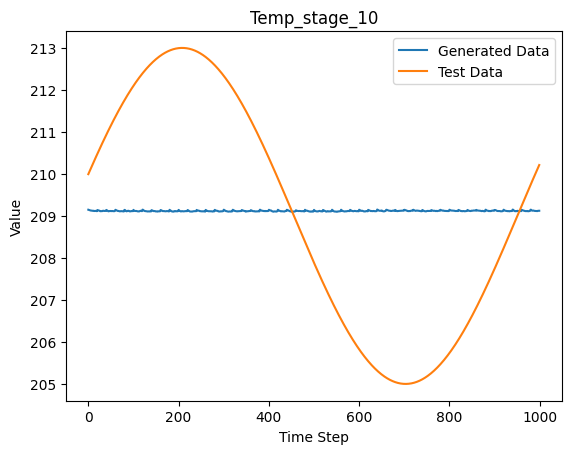

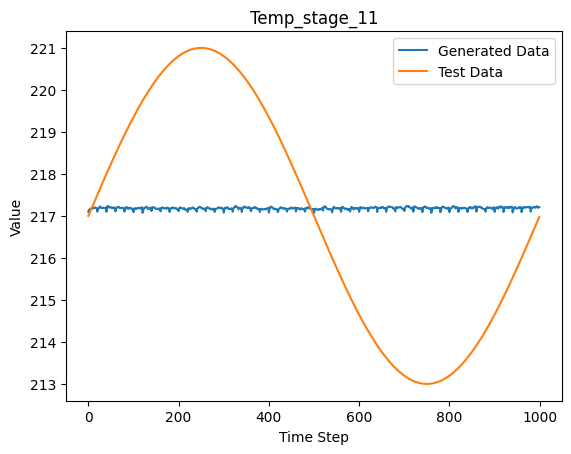

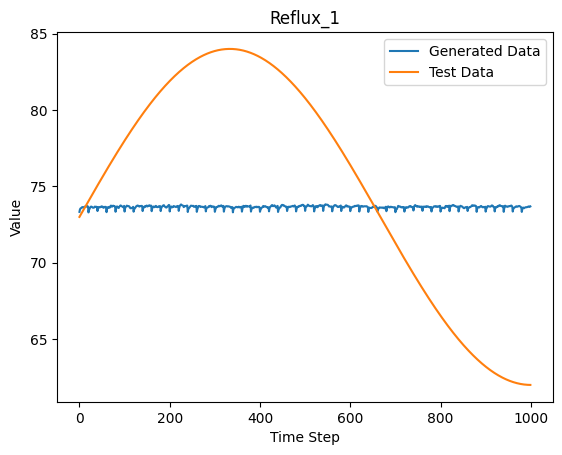

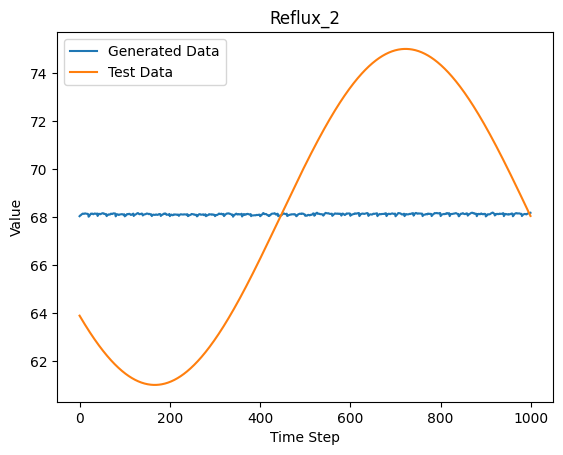

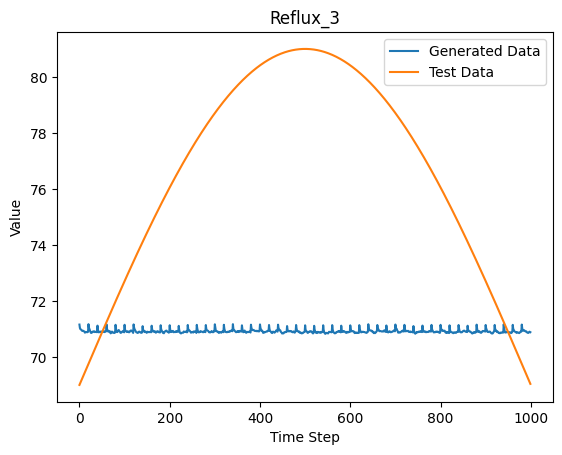

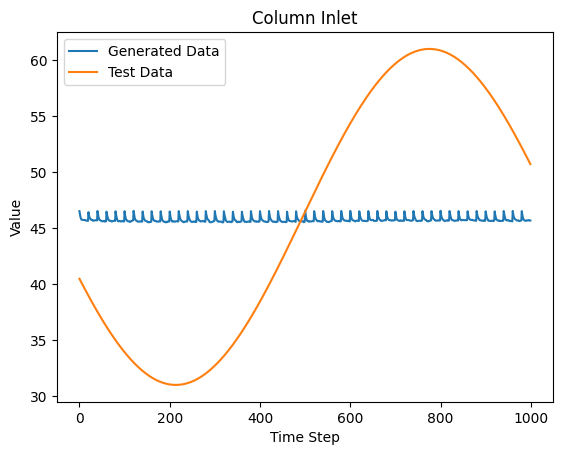

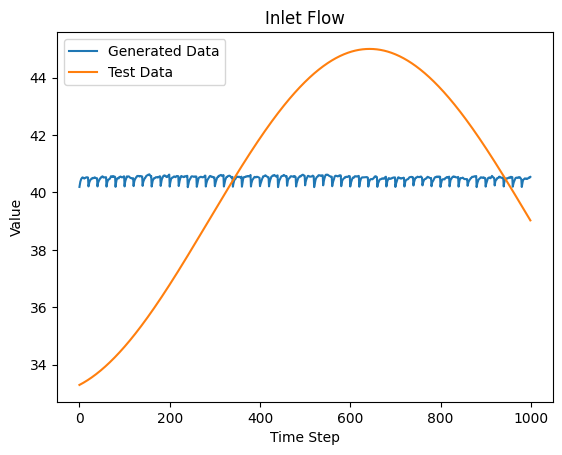

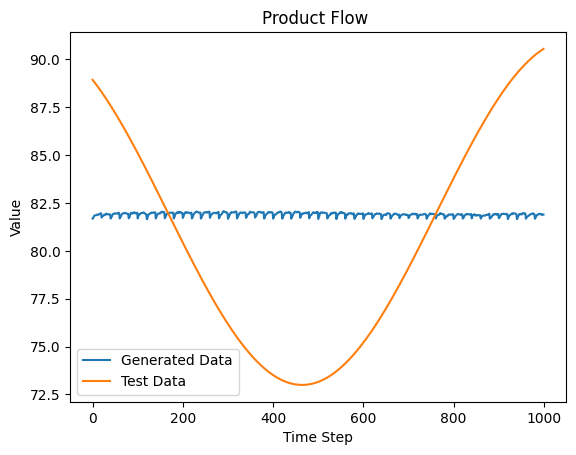

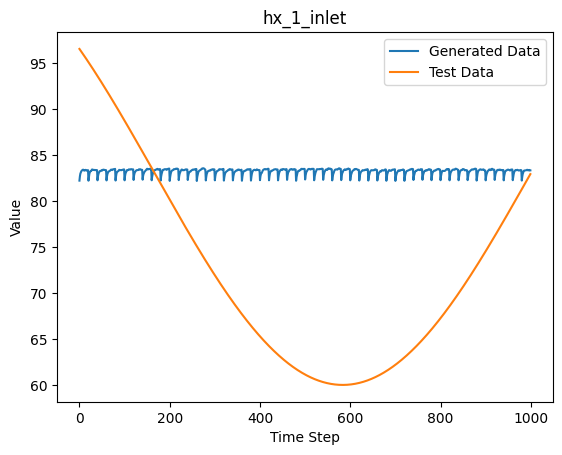

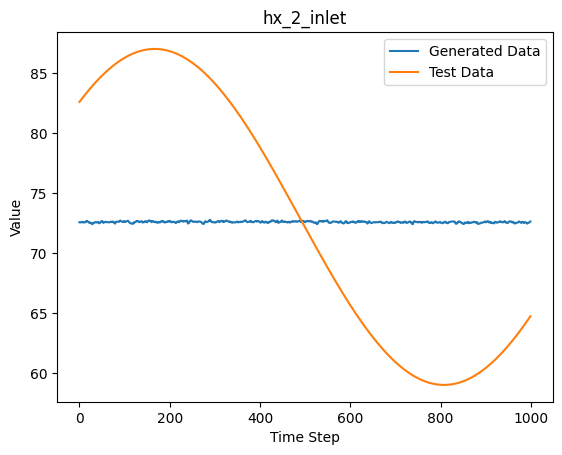

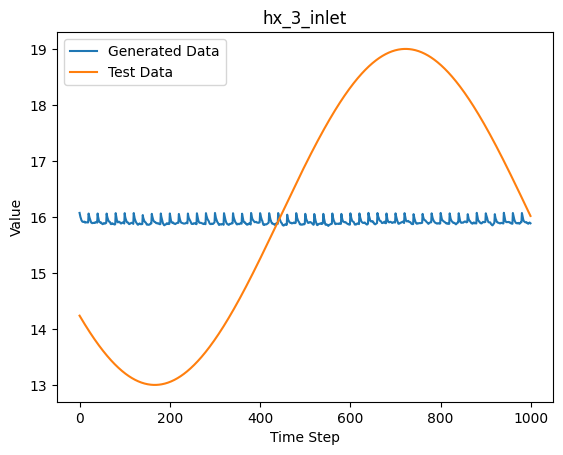

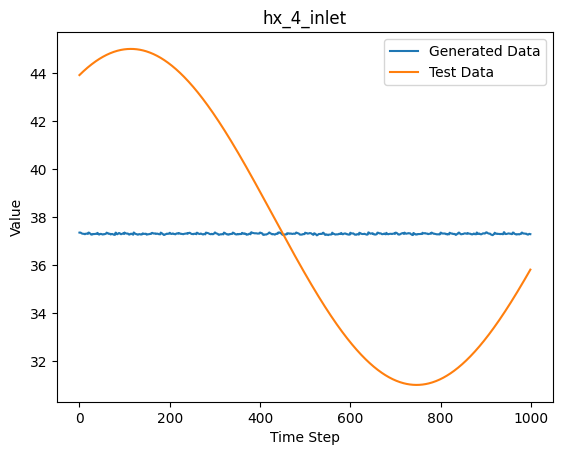

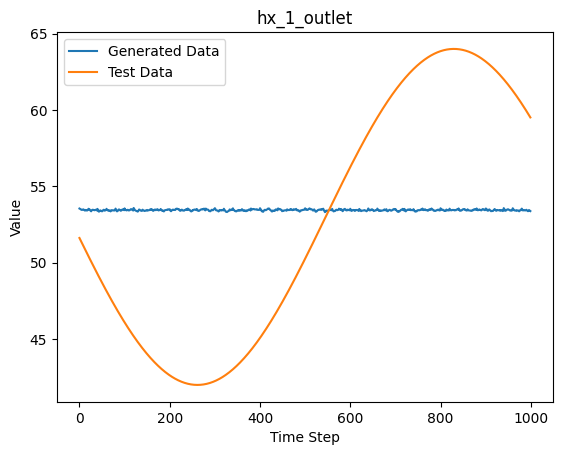

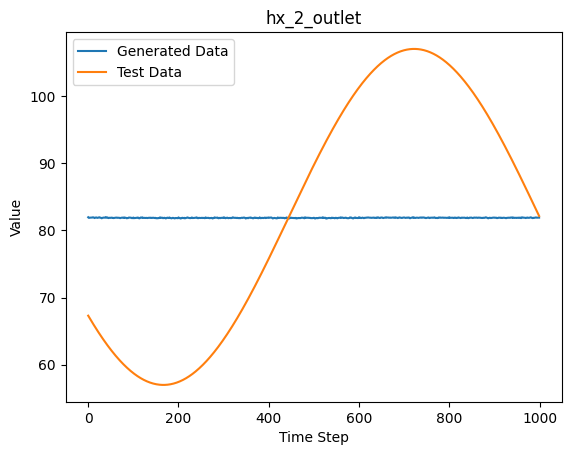

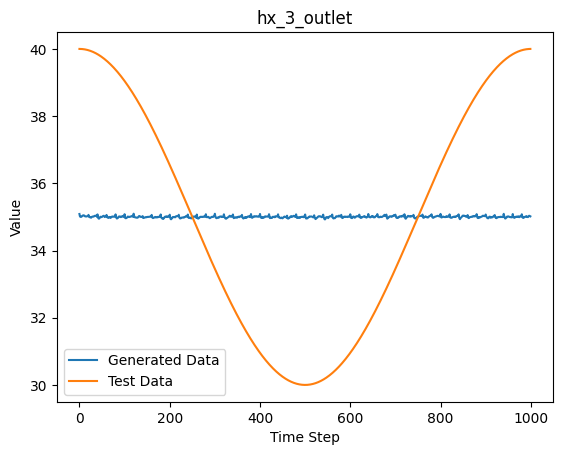

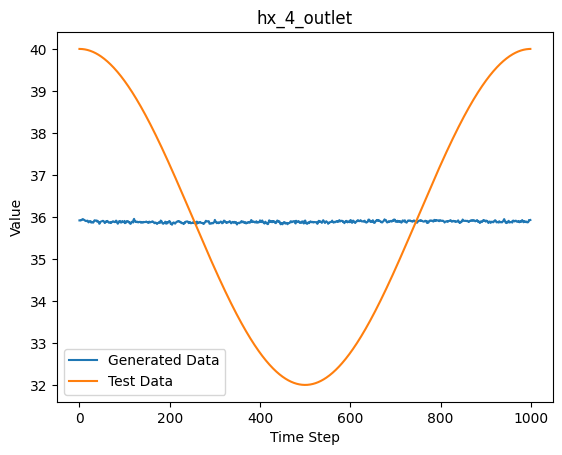

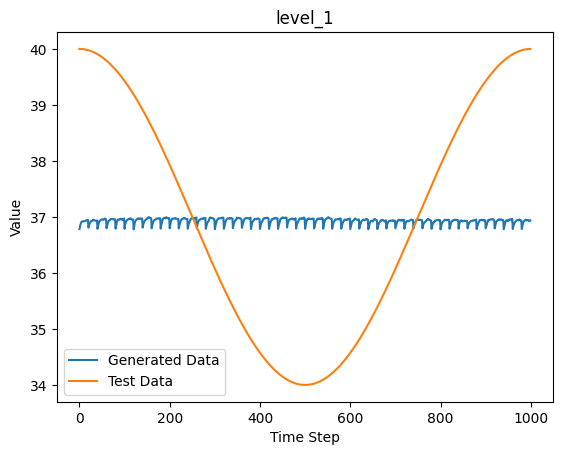

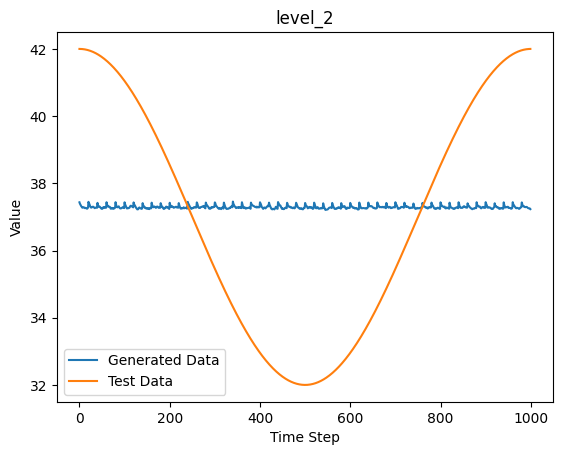

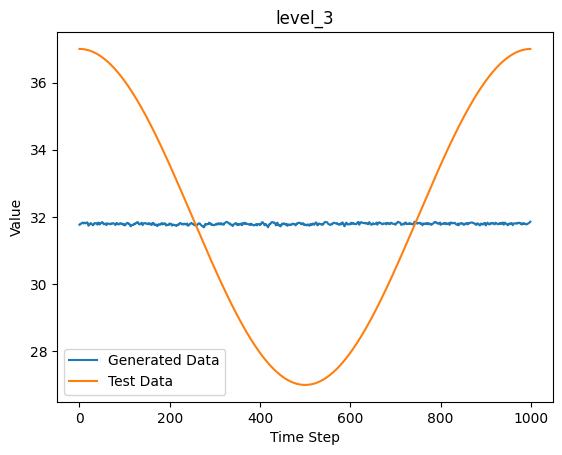

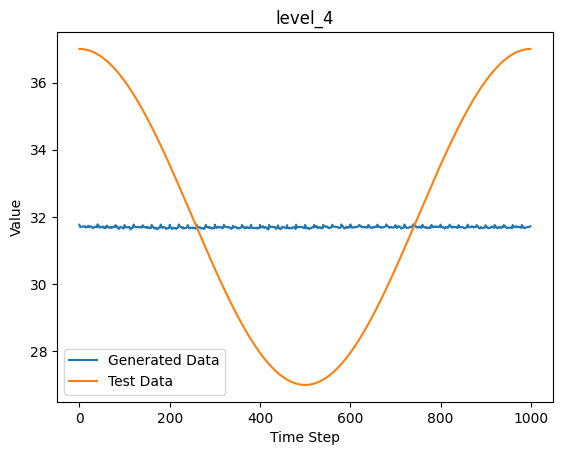

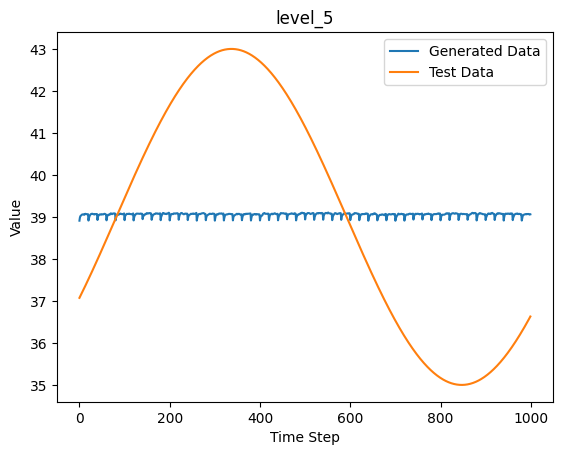

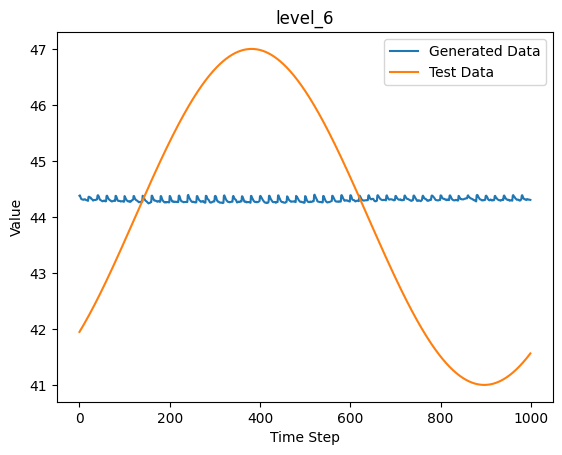

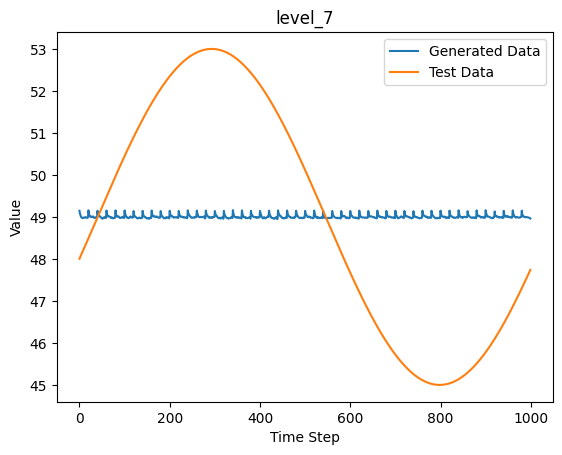

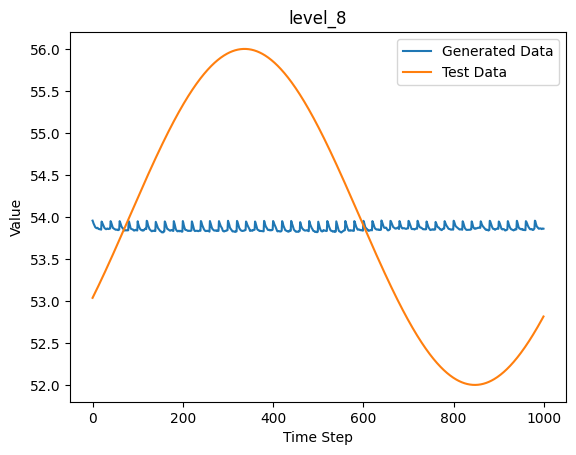

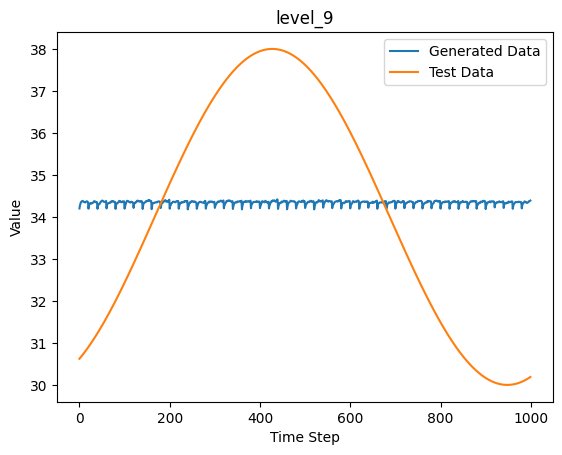

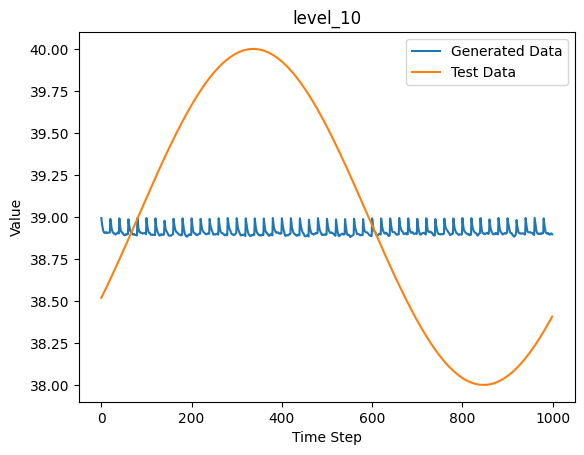

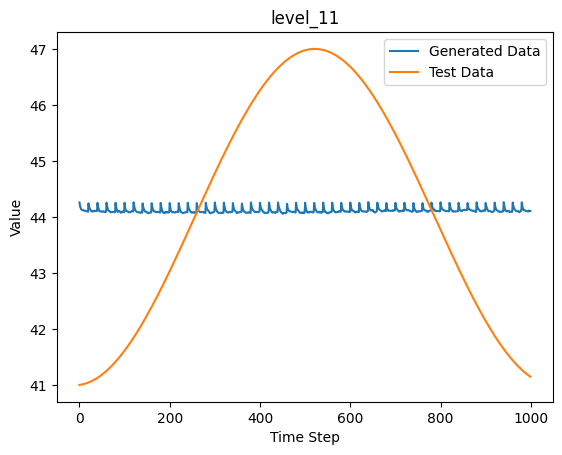

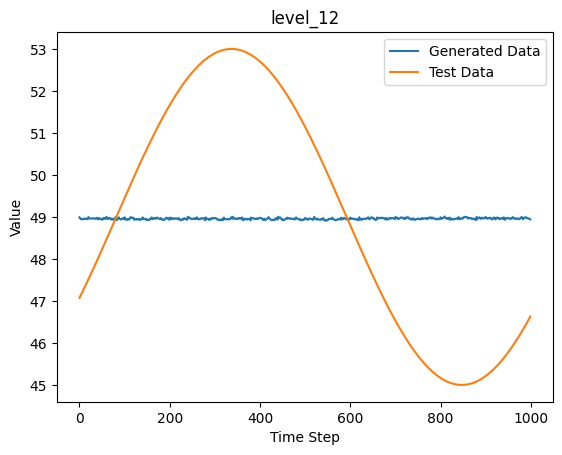

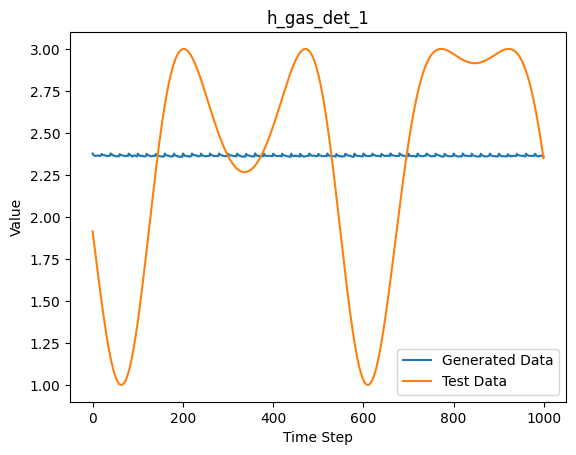

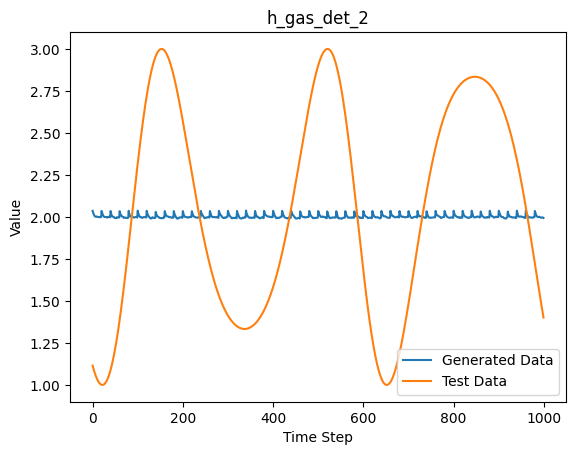

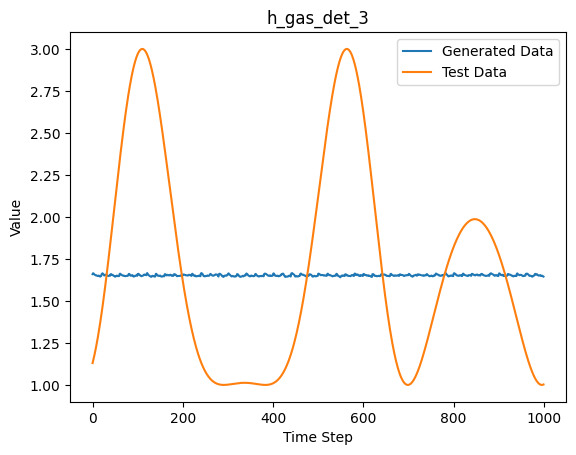

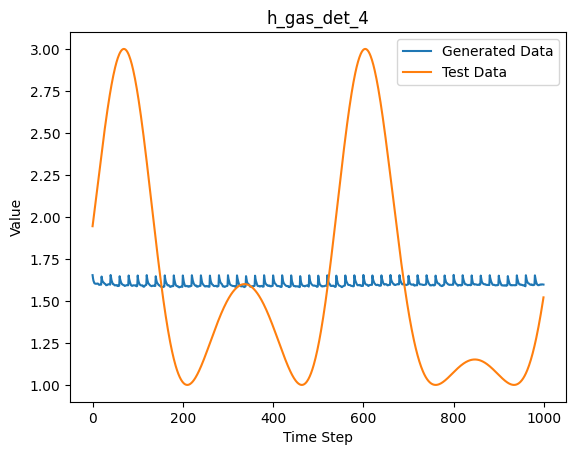

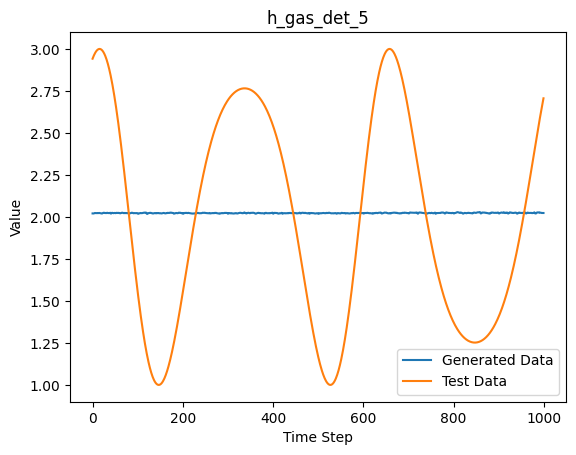

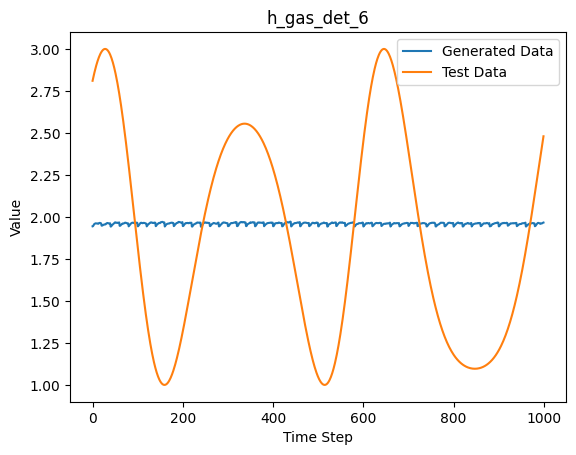

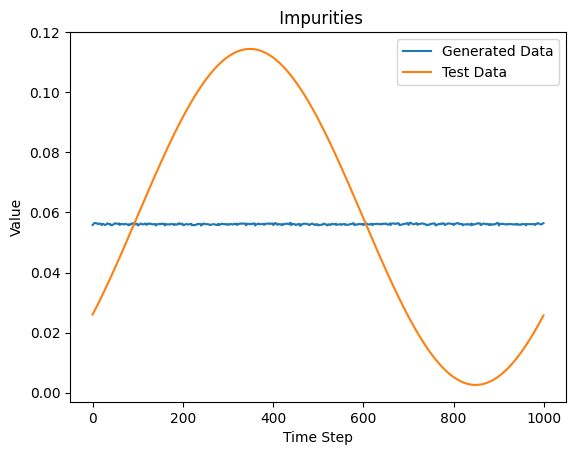

In [30]:
util.plot_features(test_data_inv, augmented_data, column_names, input_dim)

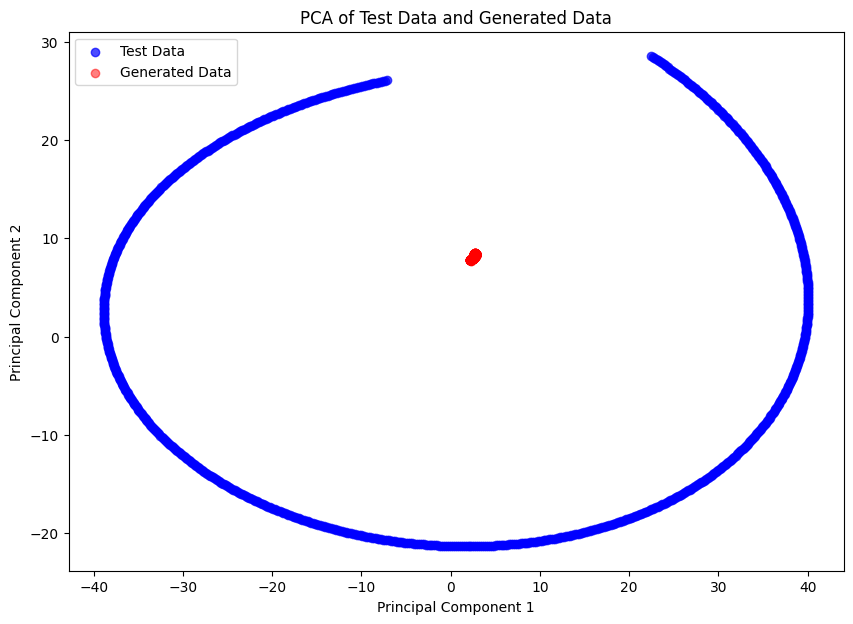

In [31]:
util.plot_pca(test_data_inv, augmented_data)

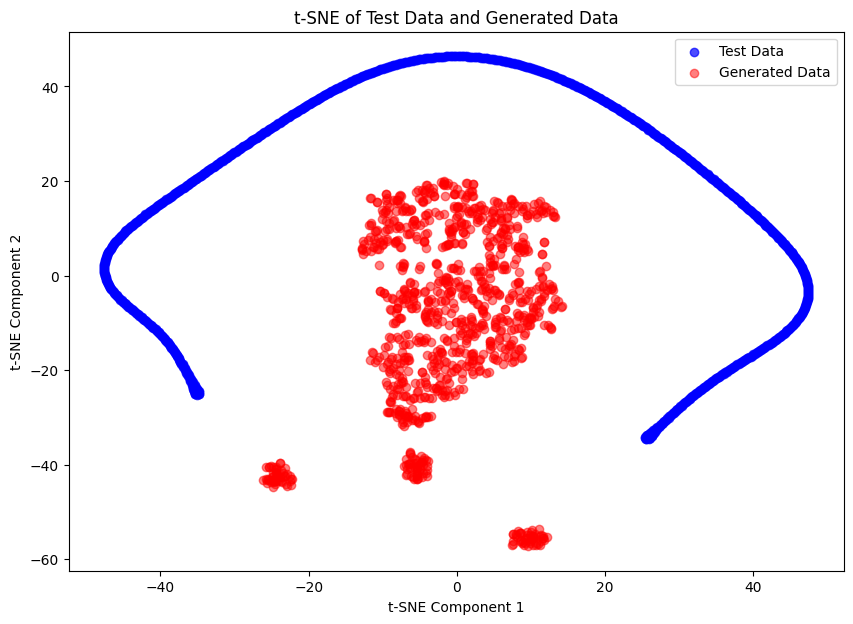

In [32]:
util.plot_tsne(test_data_inv, augmented_data)